# RouteE 101: Use pre-trained models

This notebook is an introduction to the RouteE vehicle energy prediction engine. The RouteE source code is available in [this repository](https://github.nrel.gov/MBAP/routee-powertrain). If you do not currently have access to the repo, email Jacob.Holden@nrel.gov to request access. This notebook primarily demonstrates __how to apply the default library of pre-trained RouteE models__ to estimate vehicle energy consumption. The code in this notebook should execute without issue if you clone the routee repo to the same location (and directory level) as this routee-notebooks repo.

The routee-powertrain package is now pip-installable. Be sure to follow the setup instructions in the README (rendered by default when following the GitHub link above) in order to configure a RouteE environment and install routee-powertrain. 

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nrel.routee.powertrain as pt
pd.set_option('display.max_columns', None)

In [2]:
## Newly trained model using updated RouteE powertrain
new_m = pt.load_model('/kfs2/projects/mbap/Zhaocai/Zhaocai/routee-transit-pipeline/_04_RouteE_Training/SLC_BEB.json')


In [3]:
new_m

========================================
Model Summary
--------------------
Vehicle description: BEB Vehicle
Powertrain type: ICE
Number of estimators: 1
========================================
Estimator Summary
--------------------
Feature: gpsspeed (mph)
Feature: grade (decimal)
Distance: miles (miles)
Target: kWhs (kWhs_electricity)
Raw Predicted Consumption: 0.862 (miles/kWhs_electricity)
Real World Predicted Consumption: 0.739 (miles/kWhs_electricity)
========================================

In [4]:
new_m.errors

====================================================
Feature Set ID:                  gpsspeed&grade
Target:                          kWhs
Link RMSE                        0.093
Link Norm RMSE                   3.565
Link Weighted RPD                1.051
Net Error                        0.054
Actual Dist/Energy               0.909
Predicted Dist/Energy            0.862
Real World Predicted Dist/Energy 0.739
====================================================

In [5]:
## Read in the GTFS speed grade data
import pandas as pd
city = 'richmond'
df_gtfs = pd.read_csv('./GTFS_Extracted_Features/gtfs_features_agg_{}.csv'.format(city))

In [6]:
df_gtfs

,trip_id,day_of_week,road_key,miles_new,grade_new,new_speed_mph,signal_count,with_stop,hour
0,1020,friday,00005556-4100-0400-0000-00000013d343,0.019586,-0.001675,29.467907,0.0,0,12.0
1,1020,friday,00005556-4100-0400-0000-00000013d42c,0.047560,0.002989,29.527559,0.0,1,12.0
2,1020,friday,00005556-4100-0400-0000-00000013d455,0.070762,0.005115,29.527559,0.0,1,12.0
3,1020,friday,00005556-4100-0400-0000-00000013d532,0.077690,0.005520,29.625114,0.0,0,12.0
4,1020,friday,00005556-4100-0400-0000-00000013d693,0.118614,-0.011804,26.531929,0.0,0,12.0
...,...,...,...,...,...,...,...,...,...
10433369,4094080,wednesday,fd8b9a2e-cf1d-49bd-80f4-14148e518adf,0.011725,0.006450,17.398393,0.0,0,22.0
10433370,4094080,wednesday,fdcc06f5-f669-4cd8-8f8a-5b73f67be635,0.007730,0.020200,35.028558,0.0,0,21.0
10433371,4094080,wednesday,fe0bb993-3302-4bbe-b6df-2467c21dc48d,0.021151,0.009675,13.670166,1.0,0,22.0
10433372,4094080,wednesday,ff21309b-c273-4403-b047-0f97db273932,0.037369,0.006150,30.447188,0.0,0,22.0


In [7]:
len(df_gtfs.trip_id.unique())

5534

In [2]:
## Check whether we have failed trips
if len(df_gtfs[df_gtfs.day_of_week.isna()].trip_id.unique()) > 0:
    print("Something is wrong with the last step _01_Trip_Feature_for_Energy_Estimation.py")

In [10]:
## Get real distance and set columns names for RouteE prediction.

df_gtfs['miles'] = df_gtfs.apply(lambda x: (1+x['grade_new']*x['grade_new'])**0.5*x['miles_new'], axis = 1)
df_gtfs['gpsspeed'] = df_gtfs['new_speed_mph']
df_gtfs['grade'] = df_gtfs['grade_new']

### Now we implement the speed adjustment ratio to convert TomTom Speed to Transit bus speed
no_stop_ratio = 1.694
with_stop_ratio = 5.437

df_gtfs['gpsspeed'] = df_gtfs.apply(lambda x: x['gpsspeed'] / no_stop_ratio if x['with_stop'] == 0 else x['gpsspeed'] / with_stop_ratio,axis = 1)

df_gtfs['predict_kWhs'] = new_m.predict(df_gtfs, feature_columns=["gpsspeed","grade"])


In [11]:
df_gtfs

,trip_id,day_of_week,road_key,miles_new,grade_new,new_speed_mph,signal_count,with_stop,hour,miles,gpsspeed,grade,predict_kWhs
0,1020,friday,00005556-4100-0400-0000-00000013d343,0.019586,-0.001675,29.467907,0.0,0,12.0,0.019586,17.395459,-0.001675,0.048199
1,1020,friday,00005556-4100-0400-0000-00000013d42c,0.047560,0.002989,29.527559,0.0,1,12.0,0.047560,5.430855,0.002989,0.143133
2,1020,friday,00005556-4100-0400-0000-00000013d455,0.070762,0.005115,29.527559,0.0,1,12.0,0.070763,5.430855,0.005115,0.212962
3,1020,friday,00005556-4100-0400-0000-00000013d532,0.077690,0.005520,29.625114,0.0,0,12.0,0.077691,17.488261,0.005520,0.195916
4,1020,friday,00005556-4100-0400-0000-00000013d693,0.118614,-0.011804,26.531929,0.0,0,12.0,0.118622,15.662295,-0.011804,0.305301
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10433369,4094080,wednesday,fd8b9a2e-cf1d-49bd-80f4-14148e518adf,0.011725,0.006450,17.398393,0.0,0,22.0,0.011726,10.270598,0.006450,0.031876
10433370,4094080,wednesday,fdcc06f5-f669-4cd8-8f8a-5b73f67be635,0.007730,0.020200,35.028558,0.0,0,21.0,0.007731,20.678015,0.020200,0.018580
10433371,4094080,wednesday,fe0bb993-3302-4bbe-b6df-2467c21dc48d,0.021151,0.009675,13.670166,1.0,0,22.0,0.021152,8.069756,0.009675,0.061773
10433372,4094080,wednesday,ff21309b-c273-4403-b047-0f97db273932,0.037369,0.006150,30.447188,0.0,0,22.0,0.037370,17.973547,0.006150,0.086966


In [12]:
### Add HVAC impact

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings("ignore")
import matplotlib.dates as md

import matplotlib.dates as mdates

tmy_stations = pd.read_csv('./Temp_HVAC/input-data/tmy3/tmy3_stations.csv')

states_gdf = gpd.read_file('./Temp_HVAC/input-data/geo/US_states/cb_2017_us_state_500k.shp')
states_gdf = states_gdf.rename(columns={'GEOID': 'state_fips',
                                        'NAME': 'state_name'})

tmy_stations_gdf = gpd.GeoDataFrame(tmy_stations, 
                                    geometry=gpd.points_from_xy(tmy_stations.longitude, tmy_stations.latitude))
tmy_stations_gdf.crs = "EPSG:4326"
tmy_stations_gdf = tmy_stations_gdf.to_crs(states_gdf.crs)

tmy_stations_gdf = tmy_stations_gdf.sjoin(states_gdf[['state_fips', 'state_name', 'geometry']], how='left')
tmy_stations_gdf.drop(columns=['index_right'], inplace=True)

### Pick the day with the highest temperature and lowest temperature to estimate hour-based HVAC and BTMS power

temperature_list = [-10,-5,0,5,10,15,20,25,30,35,40]
HVAC_power_list = [25,17,10,6,4,1,1,2,4,7,11]
BTMS_power_list = [4.9,3.6,2.1,0.8,0.2,0.1,0.1,1.4,1.5,2.1,5.6]

total_temp_energy_list = [HVAC_power_list[i] + BTMS_power_list[i] for i in range(len(HVAC_power_list))]

## Add two extreme values to make sure we cover all temperature values

min_temp = -100
max_temp = 100
min_temp_power = (-10 - min_temp) * (total_temp_energy_list[0] - total_temp_energy_list[1]) / 5 + total_temp_energy_list[0]
max_temp_power = (max_temp - 40) * (total_temp_energy_list[-1] - total_temp_energy_list[-2]) /5 + total_temp_energy_list[-1]

### Extend temp and energy list

temperature_list = [-100] + temperature_list + [100]
total_temp_energy_list = [min_temp_power] + total_temp_energy_list + [max_temp_power]

### Define a dataframe to store the information
df_temp_energy = pd.DataFrame({'Temp_C':temperature_list,'Power':total_temp_energy_list})

## Fill every integer Temp_C
df_tmp_fill = pd.DataFrame({'Temp_C':[i for i in range(-100,101)]})

df_temp_energy = df_tmp_fill.merge(df_temp_energy,on='Temp_C',how= 'left')

## Linear interpolate
df_temp_energy['Power'] = df_temp_energy['Power'].interpolate(method='linear')

df_temp_energy['Temp_C'] = df_temp_energy['Temp_C'].astype(float)


### We might further find the stations within the transit system's service area

# load shape data where we can get the min and max of lat/lon
df_shape = pd.read_csv(f'./GTFS_Data/{city}/shapes.txt', sep=',', header=0)

### Get the max and min of lat/lon
min_lat = df_shape.shape_pt_lat.min()
max_lat = df_shape.shape_pt_lat.max()

min_lon = df_shape.shape_pt_lon.min()
max_lon = df_shape.shape_pt_lon.max()


### Now we try to extract all stations within the bounding box
from geopy.distance import great_circle


state_tmy_stations_gdf = tmy_stations_gdf[(tmy_stations_gdf.latitude <= max_lat) &
                                           (tmy_stations_gdf.latitude >= min_lat) & 
                                            (tmy_stations_gdf.longitude <= max_lon) &
                                            (tmy_stations_gdf.longitude >= min_lon) ].reset_index(drop=True)
### If no weather stations within the bounding box, we find the station nearest to the center of the bounding box
if state_tmy_stations_gdf.shape[0] == 0:
    ## Calculate the center point
    lat_center = (min_lat + max_lat)/2
    lon_center = (min_lon + max_lon)/2
    ## calculate the great_circle distance to each station
    tmy_stations_gdf['GCD_dist'] = tmy_stations_gdf.apply(lambda x: great_circle((lat_center,lon_center), (x['latitude'], x['longitude'])).mi)

    state_tmy_stations_gdf = tmy_stations_gdf[tmy_stations_gdf['GCD_dist'] == tmy_stations_gdf['GCD_dist'].min()]   

# Get the hourly TMY3 data (per station)
tmy3_data = pd.read_csv('./Temp_HVAC/input-data/tmy3/tmy3_hourly_data.csv', parse_dates=['ts'])
tmy3_data['date'] = tmy3_data.ts.dt.date
tmy3_data = tmy3_data.sort_values(by='drybulb_c', ascending=True)

### Based on the above observation, we decide to drop the last two days
print(tmy3_data.shape[0])
tmy3_data = tmy3_data[~tmy3_data['date'].isin([datetime.date(2002, 1, 1),datetime.date(2002, 1, 2)])]
print(tmy3_data.shape[0])

## Extract data for the region of interest and look at the distribution/variation of the temperature

tmy3_data_region = tmy3_data[tmy3_data.usaf.isin(state_tmy_stations_gdf['usaf'].unique())]

### Get the hour of the day
tmy3_data_region['hod'] = tmy3_data_region['ts'].dt.hour

### Merge the temparature-based power values
tmy3_data_region = pd.merge_asof(tmy3_data_region, df_temp_energy,
                                            left_on='drybulb_c',
                                            right_on='Temp_C',
                                            direction='forward')

### Check the daily average for each station and each day

tmy3_data_region_group = tmy3_data_region.groupby(['usaf','date']).agg({'drybulb_c':['mean','max','min']})
tmy3_data_region_group.columns = ['c_mean','c_max','c_min']
tmy3_data_region_group = tmy3_data_region_group.reset_index()

#### Get the coldest and hottest date for each station
#### And extract the corresponding power consumption data
list_df_hot = []
list_df_cold = []
for usaf_tmp in tmy3_data_region_group.usaf.unique():
    df_station_tmp = tmy3_data_region_group[tmy3_data_region_group.usaf == usaf_tmp]
    cold_day = df_station_tmp[df_station_tmp.c_mean == df_station_tmp.c_mean.min()]['date'].iloc[0]
    hot_day = df_station_tmp[df_station_tmp.c_mean == df_station_tmp.c_mean.max()]['date'].iloc[0]

    df_cold = tmy3_data_region[(tmy3_data_region.usaf == usaf_tmp)&(tmy3_data_region.date == cold_day)]
    df_hot = tmy3_data_region[(tmy3_data_region.usaf == usaf_tmp)&(tmy3_data_region.date == hot_day)]
    ### Take the hourly average within each day to deal with situations where mutiple values are recorded for one hour
    df_cold_hourly = df_cold.groupby('hod').agg({"usaf":'first','ts':'first',"drybulb_c":"mean","date":'first',"Temp_C":'mean',"Power":"mean",})
    df_hot_hourly = df_hot.groupby('hod').agg({"usaf":'first','ts':'first',"drybulb_c":"mean","date":'first',"Temp_C":'mean',"Power":"mean",})
    df_cold_hourly = df_cold_hourly.reset_index()
    df_hot_hourly = df_hot_hourly.reset_index()
    
    list_df_hot.append(df_hot_hourly)
    list_df_cold.append(df_cold_hourly)

df_hot_all = pd.concat(list_df_hot)
df_cold_all = pd.concat(list_df_cold)

### Next lets get the hourly average values for all stations

df_cold_hourly = df_cold_all.groupby(['hod']).agg({"Power":"mean"})
df_hot_hourly = df_hot_all.groupby(['hod']).agg({"Power":"mean"})

df_cold_hourly = df_cold_hourly.reset_index()
df_hot_hourly = df_hot_hourly.reset_index()

8935200
8926692


In [13]:
### Rename power for summer and winter

df_cold_hourly = df_cold_hourly.rename(columns={'Power': 'winter_power'})
df_hot_hourly = df_hot_hourly.rename(columns={'Power': 'summer_power'})

In [17]:

# load data
df_shape = pd.read_csv(f'./GTFS_Data/{city}/shapes.txt', sep=',', header=0)
df_route = pd.read_csv(f'./GTFS_Data/{city}/routes.txt', sep=',', header=0)
df_trips = pd.read_csv(f'./GTFS_Data/{city}/trips.txt', sep=',', header=0)
df_stops = pd.read_csv(f'./GTFS_Data/{city}/stops.txt', sep=',', header=0)
df_stops_times = pd.read_csv(f'./GTFS_Data/{city}/stop_times.txt', sep=',', header=0)

trip_route = pd.merge(df_trips, df_route, how='left', on='route_id')
trip_route = trip_route[trip_route['route_type'] == 3]  # select only bus services (route_type = 3)

df_stops_times = pd.read_csv(f'./GTFS_Data/{city}/stop_times.txt', sep=',', header=0)

df_stops_times_group = df_stops_times.groupby('trip_id').agg({'arrival_time':'first', 'departure_time':'last',\
                                                               'stop_id':['first','last']}).reset_index()    
df_stops_times_group.columns = ['trip_id', 'o_time','d_time','o_stop_id','d_stop_id'] 

### Merge trip_route with df_stops_times_group 
trip_route = pd.merge(trip_route, df_stops_times_group, how='left', on='trip_id')
trip_route['o_time'] = pd.to_timedelta(trip_route['o_time'])
trip_route['d_time'] = pd.to_timedelta(trip_route['d_time'])   

trip_route['trip_duration'] = trip_route['d_time'] - trip_route['o_time']

In [18]:
### Now merge HVAC power to the RouteE predicted energy

### Merge df_gtfs with df_cold_hourly and df_hot_hourly
df_gtfs = df_gtfs.merge(df_cold_hourly,left_on = 'hour',right_on = 'hod',how = 'left')

df_gtfs = df_gtfs.merge(df_hot_hourly,left_on = 'hour',right_on = 'hod',how = 'left')


In [20]:
### Aggregate to get trip-level energy consumption
### We don't consider stop-based charging for now due to lack of stop dwell time data 

df_gtfs_group = df_gtfs.groupby(['trip_id','day_of_week']).agg({'miles':'sum','predict_kWhs':'sum','winter_power':'mean','summer_power':'mean'})
df_gtfs_group = df_gtfs_group.reset_index()

In [21]:
### Now merge the trip_duration to calculate the HVAC energy

df_gtfs_group = df_gtfs_group.merge(trip_route, on = 'trip_id', how = 'left')

df_gtfs_group['trip_duration'] = df_gtfs_group['trip_duration'].apply(lambda x: x.total_seconds()/3600)

### Calculate the total energy consumption for each trip

df_gtfs_group['Total_Energy_Winter'] = df_gtfs_group['predict_kWhs'] + df_gtfs_group['winter_power']*df_gtfs_group['trip_duration']
df_gtfs_group['Total_Energy_Summer'] = df_gtfs_group['predict_kWhs'] + df_gtfs_group['summer_power']*df_gtfs_group['trip_duration']

In [22]:
df_gtfs_group['kwh_per_mile_no_HVAC'] = df_gtfs_group['predict_kWhs']/df_gtfs_group['miles']
df_gtfs_group['kwh_per_mile_with_HVAC_Summer'] = df_gtfs_group['Total_Energy_Summer']/df_gtfs_group['miles']
df_gtfs_group['kwh_per_mile_with_HVAC_Winter'] = df_gtfs_group['Total_Energy_Winter']/df_gtfs_group['miles']

In [23]:
df_gtfs_group.to_csv('./Trip_Energy_Prediction_Results/trip_energy_{}_HVAC.csv'.format(city),index = False)

Text(0, 0.5, 'Frequency')

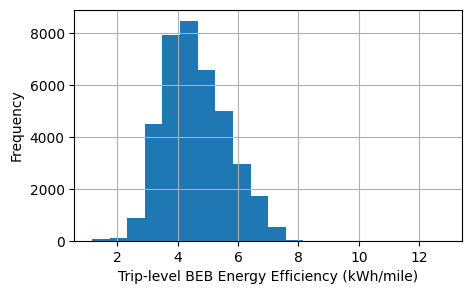

In [29]:
### Visualize energy efficiency 

import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(1, 1,figsize = [5,3])


df_gtfs_group['kwh_per_mile_with_HVAC_Winter'].hist(ax = ax,bins = 20)
plt.xlabel('Trip-level BEB Energy Efficiency (kWh/mile)')
plt.ylabel('Frequency')


#ax.set_title('Fuel Consumption Prediction',fontsize = 14,y=1.02)
#fig.savefig('./Figures/BEB_Energy_Efficiency_Trip.png',dpi = 300,bbox_inches = "tight")